In [1]:
#!pip install requests_html
#!pip install unidecode
#!pip install tika

# 0.-Importando las bibliotecas necesarias

**Para le lectura de PDF's utilizamos la biblioteca tika aquí una referencia de ella.**

https://cbrownley.wordpress.com/2016/06/26/parsing-pdfs-in-python-with-tika/

In [2]:
import pickle
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict,Counter
from unidecode import unidecode
from datetime import datetime
from tika import parser
import nltk
from nltk import corpus
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output

# 1.- Cargando Datos..

**Abrimos el pickle de la parte 1**

In [3]:
with open("abraham_nieto.pkl","rb") as f:
     sal=pickle.load(f)
     f.close()

In [4]:
df=sal["data"]
df.head()

,text,url,category
date,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa


# 2.-Armando la extracción de un documento con un ejemplo:

**Usamos parser que es una función de la librería tika, por ejemplo leemos el documento del renglón 5 de nuestro dataframe.**

In [5]:
urll=df["url"][4]#Leemos el documento del renglón 5
raw = parser.from_file(urll)#usando parser guardamos el objeto del documento
clear_output()
raw['content']#vemos el pdf convertido en un texto.

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMicrosoft Word - BOLETIN 20080620-JUNIO DEFINITIVO.DOC\n\n\n\xa0\n20 de junio de 2008 \n\nComunicado de Prensa \n \n\nAnuncio de Política Monetaria  \n\nLa Junta de Gobierno del Banco de México ha decidido incrementar a 7.75 por ciento el objetivo \npara la Tasa de Interés Interbancaria a 1 día. \n \nLa economía mundial continúa desacelerándose y la actividad económica en Estados Unidos se \nmantiene débil. A este respecto, se vislumbra un periodo prolongado de ajuste en ese país, conforme se \nreconstituya el ahorro de los hogares. Al mismo tiempo, se han intensificado las presiones \ninflacionarias en el mundo, debido a los fuertes incrementos en los precios de los alimentos, de los \nenergéticos y de otras materias primas.  Prácticamente todos los Bancos Centrales han revisado al alza \nsus previsiones sobre la inflación.  Algunos, en los principales países desarrollados, han expresado su \ncrecient

**Identificamos la palabra "Anuncio de Política Monetaria" como el patrón a encontrar ya que aparece en todos los documentos, por otro lado vamos a tomar este patrón como el punto de partida para leer cada documento**

In [6]:
pat="Anuncio de Política Monetaria"#este pat lo usaremos para todos los documentos...
corp=raw["content"]
init_p=corp.find(pat)
corp=corp[init_p+len(pat):]#Comenzar a leer el texto después del patrón.
corp[0:123]

'  \n\nLa Junta de Gobierno del Banco de México ha decidido incrementar a 7.75 por ciento el objetivo \npara la Tasa de Interés'

# 3.-Limpieza y extracción de texto

**Comenzamos creando una finción para quitar todos los caracteres que no sean palabras y los acentos**

In [7]:
def clean_d(doc):
    """Funcion que quita del texto caracteres+espacios que no son palabras y acentos
    Entrada:
          doc.-texto del docuemnto a limpiar
    Salida:
          mismo texto con solo alfanuméricos.
    """
    return unidecode(re.sub("[^\w ]","",doc.lower()))

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abraham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Stopwords**

**Hacemos la lista de stopwords que omitiremos dentro de nuestro ejercicio, además de las stopwords comunes como artículos, etc. añadimos ciertas palabras que pueden obviar el modelo o que aparecen indistintamente sin importar la clase**

In [9]:
#agregamos unalista de palabras [mantener,dsmunuir,aumentar] para no redundar el modelo
#el texto seimpre comienza con:
#La la junta de gobierno del banco de mexico ha decidido y tambien tiene "tasa de interes interbancaria a" y la palabra objetivo
#estas palabras tambien las consideraremos stop words y las agregaremos.
stopwords=(corpus.stopwords.words("spanish")+["mantener","disminuir","incrementar"]+
           "la junta de gobierno del banco de mexico ha decidido incrementar a".split()+
           "tasa de interes interbancaria a".split())

**Convirtiendo Texto en dataframe con un ejemplo...**

In [10]:
d1=re.sub("[\d]","",clean_d(corp))#quitamos todos los numeros para solo trabajar con palabras
palab=[word for word in d1.split() if word not in stopwords]
d=dict(Counter(palab))
df1=pd.DataFrame.from_dict(d,orient="index",columns=[df["category"][4]])
df1.head()

,incrementa
ciento,5
objetivo,2
dia,2
economia,2
mundial,1


**Funcion para hacer DataFrame de palabras de un documento**

In [11]:
def palabras(url,pat,name):
    """Funcion que lee un documento de una url y lo convierte en un dataframe con la frecuencia de cada palabra encontrada
    Entrada:
          url.-string de la liga donde encuentra el documento
          pat.-la palabra que se va a buscar en el documento para tomarla como el comienzo del texto de interes
          name.-nombre que le queremos poner  a la clumna del dataframe resultante
    Salida:
          df1.-pandas dataframe 
    """
    
    raw = parser.from_file(url)#leemos el archivo de la url y guardamos
    clear_output()#con esta instruccion limpiamos los mensajes de conexion...
    corp=raw["content"]#obtenemos el texto
    init_p=corp.find(pat)#encontramos la frase para tomarla como reerencia del comienzo del texto
    corp=corp[init_p+len(pat):]#depués partir del pat queremos leer nuestro documento
    d1=re.sub("[\d]","",clean_d(corp))#quitamos todos los numeros para solo trabajar conpalabras
    palab=[word for word in d1.split() if word not in stopwords]#nos quedamos con la lista de palabras del doc quitando stopwords
    d=dict(Counter(palab))#hacemos diccionario de las frecuencias dee palabras
    df1=pd.DataFrame.from_dict(d,orient="index",columns=[name])#convertimos el diccionario en datframe
    return(df1)

In [12]:
pat="Anuncio de Política Monetaria"

# 4.-Data partition

**usamos el 30 % de la base para prueba**

In [13]:
df_train,df_test=train_test_split(df,test_size=.3,random_state=345)

# 5.-Haciendo los Dataframes con las frecuencias de Palabras para cada Clase

**Hacemos una función que toma todos los documentos de df_train que pertenecen a la clase $c \in [mantiene,incrementa,disminuye]$ de tal modo que la función "uneclas" hace un dataframe con la suma de las frecuencias de cada palabra.**

$$
\cup_{i=1}^{n_{c}}A_{c}^{i}
$$

$n_{c}$.- número de documentos de la clase $c$.

$A_{c}^{i}$.- el $i-$ésimo documento de la clase $c$

**Estas uniones se hacen con outer joins para añadir palabras nuevas que se van agregando al vocabulario.**

**Nota: TODO se hace en el dataframe de entranamiento**


In [14]:
def uneclas(clase):
    """Funcion que busca todos los documentos dentro de df_train cuya categoria es la misma..
    Entrada:
          clase.-string que significa la categoría a buscar
    Salida:
          pandas dataframe con 1 columna que suma las frecuencias de cada palabra en cada documento.
    """
    dff=df_train[df_train["category"]==clase]#filtramos sólo por la ctegoría de interes
    doc=palabras(dff["url"][0],pat,"0")#usamos la función palabras para tener el dataframe de frecuencias del  1er documento
    for i in range(1,len(dff)):
        doc=doc.join(palabras(dff["url"][i],pat,f"{i}"),how="outer")#unimos todos los dataframes de frecuencias usado outer para agregar palabras nuevas en cada iteración
    return(pd.DataFrame(doc.sum(axis=1),columns=[clase]))#al ser doc un pandas series lo convertimos en dataframe       

**Creando los dataframes de frecuencias de palabras de cada clase:**

In [15]:
%%time
##tiempo de ejecución 1 min +-
mantiene=uneclas("mantiene")
incrementa=uneclas("incrementa")
disminuye=uneclas("disminuye")

CPU times: user 3 s, sys: 188 ms, total: 3.19 s
Wall time: 9.82 s


In [16]:
mantiene.head()


,mantiene
abasto,2.0
abatir,3.0
abierto,2.0
abonado,1.0
abril,18.0


In [17]:
incrementa.head()

,incrementa
abriendo,1.0
abril,2.0
absorber,1.0
accion,2.0
acciones,11.0


In [18]:
disminuye.head()

,disminuye
abasto,1.0
abatimiento,1.0
abatir,3.0
abril,3.0
abriljunio,1.0


# 6.-Análisis de palabras por clase:

**Analizamos el número de palabras que en los documentos de cada clase**

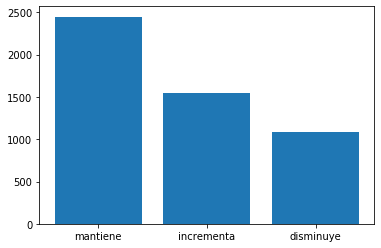

In [19]:
def frecp(mant,inc,dism):
  """Función que crea una gráfica de fecuencias de palabras,o ngramas por clase
  Entrada:
    mant.-dataframe 1
    inc.-dataframe 2
    dism.-dataframe 3
  Salida:
     matplotlib de frecuencias
  """
  vocabs=np.array([len(mant.index),len(inc.index),len(dism.index)])
  plt.bar(["mantiene","incrementa","disminuye"],vocabs)

frecp(mantiene,incrementa,disminuye)

**De las 3 clases podemos ver que "la categoría mantiene es la que mayor número de palabras podemos encontrar esto tiene sentido ya que casi el 70% de los documentos pertenecen a dicha clase en cambio "disminuye tiene menos de la mitad de las palabras de "mantiene"**

**Longitud de Palabras por Clase:**

In [20]:
dfs={"mantiene":mantiene,"incrementa":incrementa,"disminuye":disminuye}

In [21]:
def graflen(clase,cl):
  """Funcion que grafica un histograma de la distribución de la longitud de las palabra en una clase
    Entrada:
          clase.-dataframe a graficar
          cl.-color
          name.-nombre que aparece en el título
    Salida:
          histograma d la distribución
  """
  lenc=[len(w) for w in dfs[clase].index ]#lista con la longitud de cada palabra 
  print(f"la media del tamaño de palabras en la clase {dfs[clase].columns[0]} es {np.mean(lenc)}")
  plt.hist(lenc,bins=15, color=cl)#histograma
  plt.xlabel("tamaño de palabras")
  plt.ylabel("frecuencia")
  plt.show()

la media del tamaño de palabras en la clase mantiene es 8.591911764705882


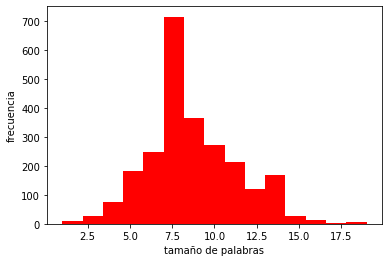

<function __main__.graflen(clase, cl)>

In [22]:
interact(graflen, clase=["mantiene","incrementa","disminuye"], cl =["r","b","g"])

**Más allá de que los promedios del tamaño de las palabras de cada clase es parecido podemos ver que la clase disminuye es la que tiene mayor cantidad de palabras cortas...**

**Uniendo las 3 clases en 1 dataframe podemos ver el tamaño del vocabulario que tenemos de todos los documentos**

In [23]:
#Hacemos el Dataframe de verosimilitud...
likeh=mantiene.join(incrementa,how="outer").join(disminuye,how="outer").fillna(0)+1

In [24]:
print(f"Tenemos dentro del vocabulario {len(likeh.index)} Palabras")

Tenemos dentro del vocabulario 2907 Palabras


**Palabras más Frecuentes por clase**

In [25]:
def mas_frec(n,dfl):
  """Funcion que grafica el top n de palabras más frecuentes por clase
    Entrada:
          n.-int número de datos mas frecuentes a mostrar
          dfl.-Dataframe a leer
    Salida:
          matplotlib graficas de barras de top n de datos más frecuentes.
  """
  fig,ax=plt.subplots(1,3,figsize=(20,5))
  dfl["mantiene"].sort_values(ascending=False)[:n].plot.bar(ax=ax[0],color="r")
  dfl["incrementa"].sort_values(ascending=False)[:n].plot.bar(ax=ax[1],color="b")
  dfl["disminuye"].sort_values(ascending=False)[:n].plot.bar(ax=ax[2],color="g")
  fig.suptitle(f"Top {n} de palabras por Clase")
  ax[0].set_xlabel("Mantiene")
  ax[1].set_xlabel("Incrementa")
  ax[2].set_xlabel("Disminuye")

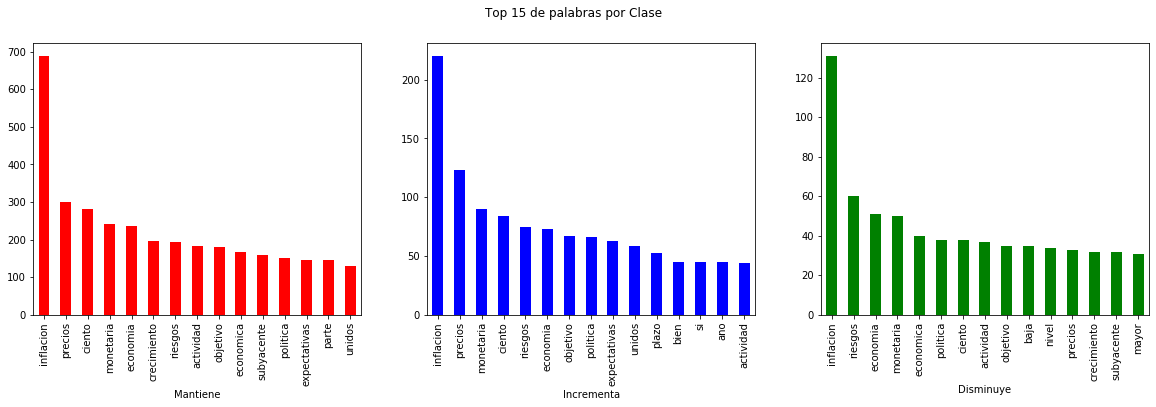

<function __main__.mas_frec(n, dfl)>

In [26]:
interact(mas_frec,n=(5,25,5),dfl=fixed(likeh))

**Dentro de las palabras más usadas esta "inflación", la cual es la más frecuente en todas las clases por tanto podemos agregarla a la lista de stopwords o en su defecto, está palabra no será relevante para diferenciar las clases, por otro lado en la clase "mantiene" la 6ta. palabra más frecuente es "crecimiento" la cual no se encuentra en el top 15 de la clase Incrementa por tanto si pudiera ser una palabra clave para diferenciar estas 2 clases, aunque está palabra para la clase "disminuye" esla 13ra. más frecuente quizás pueda confundir las clases, en la clase "disminuye" la 2da palabra más frecuente es "riesgos"**

Por otro lado no quitaremos ninguna de las palabras ya que se probarán modelos usando n-gramas además de palabras simples

# 7.-Naive Bayes...

**Creamos el dataframe de log-verosimilitud...**

In [27]:
#Creamos el dataframe de probas por palabra por clase:
likeh=likeh/likeh.sum(axis=0)
#Hacemos la log-verosimilitud
log_likeh=np.log(likeh)
log_likeh.head()

,mantiene,incrementa,disminuye
abasto,-9.060525,-9.273785,-8.199189
abatimiento,-10.159137,-9.273785,-8.199189
abatir,-8.772843,-9.273785,-7.506042
abierto,-9.060525,-9.273785,-8.892337
abonado,-9.465990,-9.273785,-8.892337


**Calculamos LOG Priors**
$$
log(P(c))=log(\frac{n_{c}}{n})
$$

$n_{c}$.- número de documentos en la clase $c$

$n$.- número de documentos totales

In [28]:
#Hacemos los log priors para cada clase...
log_prior_matiene=np.log(len(df_train[df_train["category"]=="mantiene"])/len(df_train))
log_prior_incrementa=np.log(len(df_train[df_train["category"]=="incrementa"])/len(df_train))
log_prior_disminuye=np.log(len(df_train[df_train["category"]=="disminuye"])/len(df_train))
log_priors=np.array([log_prior_matiene,log_prior_incrementa,log_prior_disminuye])

**La suma de priors debe ser 1 por ello imprimimos np.exp(log_priors)**

In [29]:
print(log_priors,np.exp(log_priors))

[-0.36464311 -1.79175947 -1.97408103] [0.69444444 0.16666667 0.13888889]


**Probando Naive Bayes sobre la lista palab que hicimos al principio del notebook**

In [30]:
ans=log_likeh.loc[palab].sum(axis=0)+log_priors
print(ans)
ans.idxmax()

mantiene     -1452.376819
incrementa   -1435.028928
disminuye    -1471.577543
dtype: float64


'incrementa'

# 8.-Predicciones

**Pipeline para predecir a que clase pertenece el documento que está en la url..., en otras palabras hacemos una función predict llamada "pipe_pa"**

In [31]:
def pipe_pa(url,pat):
    """Funcion que lee un documento de una url y lo categoriza en una clase según el modelo naive bayes.
    Entrada:
          url.-string de la liga donde encuentra el documento
          pat.-la palabra que se va a buscar en el documento para tomarla como el comienzo del texto de interes
    Salida:
          string que dice a la clase donde debe ser clasificado.
    """
    raw = parser.from_file(url)
    clear_output()#limpiando los mensajes de conexion por documento..
    corp=raw["content"]
    init_p=corp.find(pat)
    corp=corp[init_p+len(pat):]
    d1=re.sub("[\d]","",clean_d(corp))#quitamos todos los numeros para solo trabajar conpalabras
    palab=[word for word in d1.split() if word not in stopwords]#obtenemos la lista de palabras del docuemto sin las stopwords
    palabt=[w for w in palab if w in log_likeh.index]#filtramos la lista de palabras del documento para considerar sólo las que están en nuestro vocabulario
    return((log_likeh.loc[palabt].sum(axis=0)+log_priors).idxmax())#le pasamos el modelo naive bayes y obtenemos la caegoría.    

**probando el pipeline..**

In [32]:
pipe_pa(df_test["url"][0],pat)

'mantiene'

**Pasamos el Modelo a cada documento de df_test y obtenemos su clasificacion en la variable pred...**

In [33]:
%%time
#este proceso tarda 15 segs.
df_test["pred"]=df_test.apply(lambda row: pipe_pa(row["url"],pat),axis=1)
df_test.head()

CPU times: user 1.23 s, sys: 67.4 ms, total: 1.3 s
Wall time: 4.53 s


/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,url,category,pred
date,,,,
2015-10-29,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene
2012-08-06,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene
2011-04-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene
2010-07-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene
2018-11-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,incrementa


# 9.-Validación

**Finalmente revisamos los resultados del modelo a tráves de la función kpis que genera la matriz de confusión y el reporte de clasificación para ver métricas como accuracy, recall y precision entre otros...**

In [34]:
def kpis(test,pred):
  """Funcion que genera Matriz de confusión y reporte de clasificación
    Entrada:
          test.-array strings de etiquetas verdaderas de cada clase
          pred.-array strings de etiquetas de predicción de cada clase
    Salida:
          print de matriz de confusión y reporte
  """  
  print(f'el % de clases bien clasificadas es: {accuracy_score(test,pred)*100}')
  #Creamos la matriz de confusión...
  cm=confusion_matrix(test,pred,labels=["mantiene","disminuye","incrementa"])
  print(cm)
  labels=["mantiene","disminuye","incrementa"]
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='seismic')
  for (i, j), z in np.ndenumerate(cm):
      ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',color="w")
  #plt.title('Matriz de Confusión',loc='left')
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  print(classification_report(test,pred))

el % de clases bien clasificadas es: 81.25
[[20  1  1]
 [ 1  3  0]
 [ 3  0  3]]


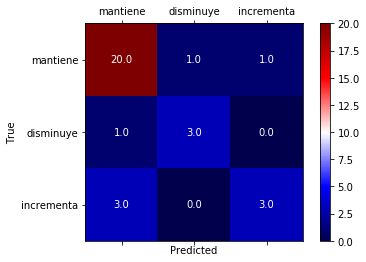

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       0.75      0.50      0.60         6
    mantiene       0.83      0.91      0.87        22

    accuracy                           0.81        32
   macro avg       0.78      0.72      0.74        32
weighted avg       0.81      0.81      0.80        32



In [35]:
kpis(df_test["category"],df_test["pred"])

**La clase que más le cuesta clasificar correctamente es la de incrementa ya que si vemos el reporte, el recall muestra un 50% lo que significa que la mitad de los casos de esta clase están mal clasificados en este caso son 3 que se predijeron como "mantiene", por otro lado 91%(20/22) de los documentos de la clase mantiene fueron bien clasificados(recall), para la clase disminuye se predijeron 4 documentos que pertencían a esta y 3 estaban correcto (precision).** 

# 10.-N-gramas

**Y si usamos n-gramas ¿Podemos mejorar la asertividad del Modelo?**

**Haciendo funciones similares para usar los ngramas como vocabularios...**

Función que Convierte la lista de n-gramas de tamaño $n$ en dataframe

In [36]:
def pagramas(url,pat,name,ngrama):
    """Funcion que lee un documento de una url y lo convierte en un dataframe con la frecuencia de cada ngrama de tamaño ngrama
    Entrada:
          url.-string de la liga donde encuentra el documento
          pat.-la palabra que se va a buscar en el documento para tomarla como el comienzo del texto de interes
          name.-nombre que le queremos poner  a la clumna del dataframe resultante
          ngrama.-número de palabras a juntar y contar como 1 sola.
    Salida:
          df1.-pandas dataframe 
    """  
    
    raw = parser.from_file(url)#leemos el archivo de la url y guardamos
    clear_output()#limpiando los mensajes de conexion por documento...
    corp=raw["content"]#obtenemos el texto
    init_p=corp.find(pat)#encontramos la frase para tomarla como reerencia del comienzo del texto
    corp=corp[init_p+len(pat):]#depués partir del pat queremos leer nuestro documento
    d1=re.sub("[\d]","",clean_d(corp))#quitamos todos los numeros para solo trabajar conpalabras
    palab=[word for word in d1.split() if word not in stopwords]#nos quedamos con la lista de palabras del doc quitando stopwords
    palag=list(nltk.ngrams(palab,ngrama))#creamos la lista de ngramas que existen
    d=dict(Counter(palag))#hacemos diccionario de las frecuencias de ngramas
    df1=pd.DataFrame.from_dict(d,orient="index",columns=[name])#convertimos el diccionario en datframe
    return(df1)

**Ejemplo 3-grama...**

In [37]:
pagramas(urll,pat,df["category"][4],3).head()

,incrementa
"(ciento, objetivo, dia)",2
"(objetivo, dia, economia)",1
"(dia, economia, mundial)",1
"(economia, mundial, continua)",1
"(mundial, continua, desacelerandose)",1


Función uneclas_g une todos los $n-$gramas de la clase $c$

In [38]:
def uneclas_g(clase,ngrama):
    """Funcion que busca y une todos los documentos dentro de df_train cuya categoria es la misma..
    Entrada:
          clase.-string que significa la categoría a buscar
          ngrama.-int el tamaño del nrama
    Salida:
          pandas dataframe con 1 columna que suma las frecuencias de cada ngrama en cada documento.
    """  
    dff=df_train[df_train["category"]==clase]#filtramos sólo por la ctegoría de interes
    doc=pagramas(dff["url"][0],pat,"0",ngrama)#usamos la función pagramas para tener el dataframe de frecuencias del  1er documento
    for i in range(1,len(dff)):
        doc=doc.join(pagramas(dff["url"][i],pat,f"{i}",ngrama),how="outer")#unimos todos los dataframes de frecuencias de ngramas usado outer para agregar ngramas nuevos en cada iteración
    return(pd.DataFrame(doc.sum(axis=1),columns=[clase]))

**Haciendo los dataframes de $3-$gramas por clase**

In [39]:
%%time
#este código tarda 1min..
mantiene_3=uneclas_g("mantiene",3)
incrementa_3=uneclas_g("incrementa",3)
disminuye_3=uneclas_g("disminuye",3)

CPU times: user 4.31 s, sys: 223 ms, total: 4.54 s
Wall time: 12 s


**Análisis de $3-$gramas por clase**

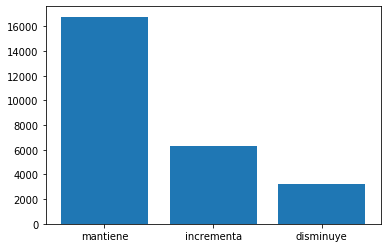

In [40]:
frecp(mantiene_3,incrementa_3,disminuye_3)

**haciendo 3-gramas la diferencia entre la clase mantiene y disminuye se duplica con respecto a sólo usar palabras**

Mostramos como se ve la clase mantiene

In [41]:
mantiene_3.head()

,mantiene
"(abasto, gas, natural)",1.0
"(abasto, incremento, precios)",1.0
"(abatir, corrupcion, combatir)",1.0
"(abatir, corrupcion, cuarto)",1.0
"(abatir, corrupcion, informacion)",1.0


**Dataframes de n-gramas**

Hacemos el dataframe de las log-verosimilitudes por clase

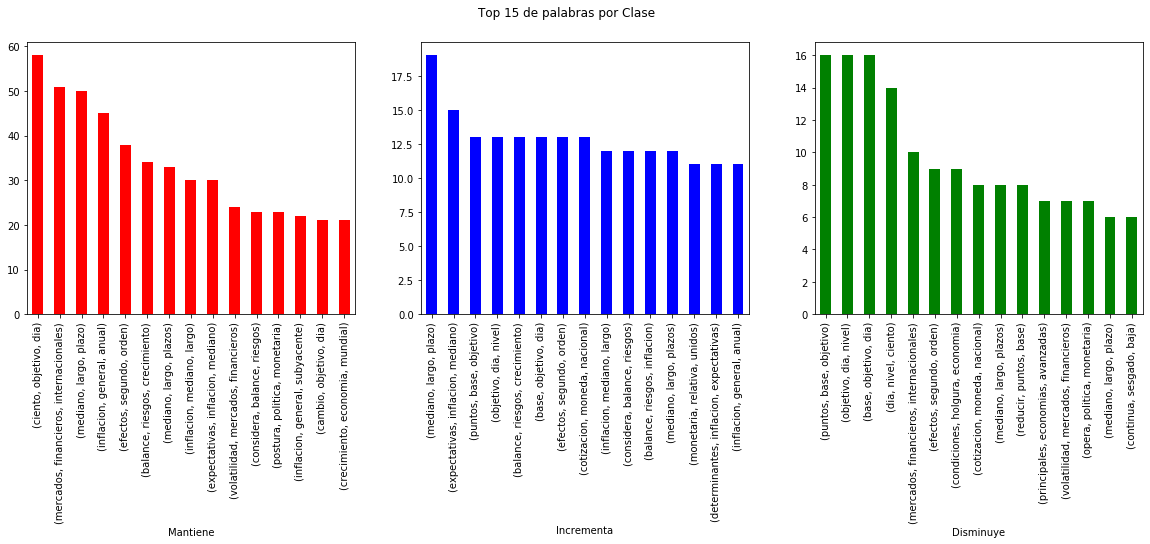

,mantiene,incrementa,disminuye
"(abasto, expectativas, inflacion)",-10.757882,-10.370487,-9.565529
"(abasto, gas, natural)",-10.064734,-10.370487,-10.258676
"(abasto, incremento, precios)",-10.064734,-10.370487,-10.258676
"(abatimiento, inflacion, facilita)",-10.757882,-10.370487,-9.565529
"(abatir, corrupcion, combatir)",-10.064734,-10.370487,-8.872382


In [42]:
likeh_g=mantiene_3.join(incrementa_3,how="outer").join(disminuye_3,how="outer").fillna(0)+1
print(f"Tenemos dentro del vocabulario {len(likeh_g.index)} ngramas")
interact(mas_frec,n=(5,25,5),dfl=fixed(likeh_g))
#mas_frec(15,likeh_g)
#Creamos el dataframe de probas por ngrama por clase:
likeh_g=likeh_g/likeh_g.sum(axis=0)
#Hacemos la log-verosimilitud
log_likeh_g=np.log(likeh_g)
log_likeh_g.head()

Hacemos la función predict para los $3-$gramas y se la aplicamos a cada docuemto del dataframe df_test guardándolo en la variable **pred3**.

In [43]:
def pipe_pag(url,pat,ngrama,dat):
    """Funcion que lee un documento de una url y lo convierte en un dataframe con la frecuencia de cada ngrama de tamaño ngrama
    Entrada:
          url.-string de la liga donde encuentra el documento
          pat.-la palabra que se va a buscar en el documento para tomarla como el comienzo del texto de interes
          name.-nombre que le queremos poner  a la clumna del dataframe resultante
          ngrama.-número de palabras a juntar y contar como 1 sola.
          dat.-Dataframe de donde se van a leer las log-verosimilitudes.
    Salida:
          df1.-pandas dataframe 
    """  
    
    raw = parser.from_file(url)#leemos el archivo de la url y guardamos
    clear_output()#limpiamos mensajes de conexion a cada documento...
    corp=raw["content"]#obtenemos el texto
    init_p=corp.find(pat)#encontramos la frase para tomarla como reerencia del comienzo del texto
    corp=corp[init_p+len(pat):]#depués partir del pat queremos leer nuestro documento
    d1=re.sub("[\d]","",clean_d(corp))#quitamos todos los numeros para solo trabajar conpalabras
    palab=[word for word in d1.split() if word not in stopwords]#nos quedamos con la lista de palabras del doc quitando stopwords
    palag=list(nltk.ngrams(palab,ngrama))#creamos la lista de ngramas que existen
    palabt=[w for w in palag if w in dat.index]#filtramos la lista de palabras del documento para considerar sólo las que están en nuestro vocabulario
    return((dat.loc[palabt].sum(axis=0)+log_priors).idxmax())#le pasamos el modelo naive bayes y obtenemos la categoría.    

In [44]:
%%time
df_test["pred3"]=df_test.apply(lambda row: pipe_pag(row["url"],pat,3,log_likeh_g),axis=1)
df_test.head()

CPU times: user 1.15 s, sys: 49.6 ms, total: 1.2 s
Wall time: 4.13 s


/home/abraham/anaconda4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,url,category,pred,pred3
date,,,,,
2015-10-29,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene,mantiene
2012-08-06,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene,mantiene
2011-04-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene,mantiene
2010-07-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,mantiene,mantiene
2018-11-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,incrementa,incrementa


# 11.-Validación Modelo 3-gramas

el % de clases bien clasificadas es: 78.125
[[19  1  2]
 [ 1  3  0]
 [ 3  0  3]]


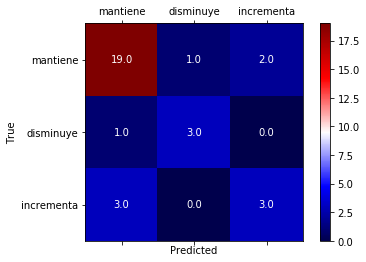

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       0.60      0.50      0.55         6
    mantiene       0.83      0.86      0.84        22

    accuracy                           0.78        32
   macro avg       0.73      0.70      0.71        32
weighted avg       0.77      0.78      0.78        32



In [45]:
kpis(df_test["category"],df_test["pred3"])

**Por tanto usar 3-gramas no mejora el modelo original de usar palabras ya que el 78.125% de los documentos están bien clasificdos vs. el 81.25% de sólo usar palabras**

# 12.-Pipeline N-gramas

**Haciendo un pipeline completo para crear un modelo con un n-grama end 2 end**

Creamos la función modelo_ngram que genere las listas de n-gramas una las clases en dataframes, haga el dataframe de verosimilitud y aplique un predict a los documentos del datframe de test.

In [46]:
def modelo_ngram(n):
  """Funcion que genera las prediciones para un n-grama de las palabras en los documentos
    Entrada:
          n.-int el tamaño del ngrama
    Salida:
          pred.- vector de clasificaciones
  """  
  mant=uneclas_g("mantiene",n)
  inc=uneclas_g("incrementa",n)
  dism=uneclas_g("disminuye",n)
  likeh_g=mant.join(inc,how="outer").join(dism,how="outer").fillna(0)+1
  print(f"Tenemos dentro del vocabulario {len(likeh_g.index)} ngramas")
  #Creamos el dataframe de probas por ngrama por clase:
  likeh_g=likeh_g/likeh_g.sum(axis=0)
  #Hacemos la log-verosimilitud
  log_likeh_g=np.log(likeh_g)
  pred=df_test.apply(lambda row: pipe_pag(row["url"],pat,n,log_likeh_g),axis=1)
  return(pred)


**Buscando el mejor modelo bajo la métrica accuracy, probando con ngramas desde 1(que es lo mismo que separar las plabras) hasta 9, veamos que combinaciones nos dan mejor accuracy y seleccionemos el mejor de los modelos...**


# 13.-Comparando múltiples modelos

**Usando la función anterior comparamos múltiples modelos donde la diferencia entre cada uno es el tamaño de n-grama que se usa como input**

**NOTA** este proceso tarda cerca de **5 mins..**

In [47]:
%%time 
acc_mod=[]#Hacemos una lista de acuracys
preds=[]#guardamos una lista de arrays de prediccionespor n-grama
for i in range(1,10):
  pred=modelo_ngram(i)
  acc_mod.append(accuracy_score(df_test["category"],pred)*100)
  preds.append(pred)  

CPU times: user 49.5 s, sys: 2.37 s, total: 51.8 s
Wall time: 2min 25s


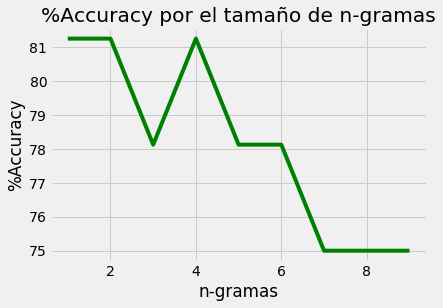

In [48]:
plt.style.use("fivethirtyeight")
plt.plot(list(range(1,10)),acc_mod,color="g")
plt.xlabel("n-gramas")
plt.ylabel("%Accuracy")
plt.title("%Accuracy por el tamaño de n-gramas")
plt.show()

**Podemos observar que los modelos con sólo palabras, 2-gramas y 4-gramas tienen el mismo accuracy, por tanto podemos  comaparlos a detalle cada uno para seleccionar por otra métrica quizás cual nos conviene usar...**

**Detalle métricas por n-grama observando n del 1 al 9**

In [49]:
def val_n(ngram):
    kpis(df_test["category"],preds[ngram-1])

el % de clases bien clasificadas es: 78.125
[[19  1  2]
 [ 1  3  0]
 [ 3  0  3]]


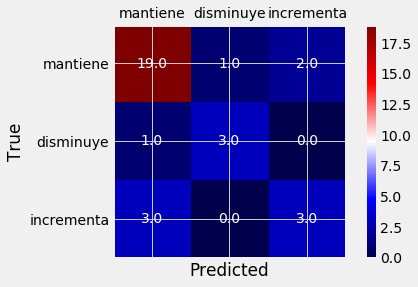

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       0.60      0.50      0.55         6
    mantiene       0.83      0.86      0.84        22

    accuracy                           0.78        32
   macro avg       0.73      0.70      0.71        32
weighted avg       0.77      0.78      0.78        32



<function __main__.val_n(ngram)>

In [50]:
interact(val_n,ngram=(1,9,1))

# 14.-Conclusiones.
**Revisamos a detalle los 3 modelos ganadores:**

Hacemos el modelo $4-$grama y también el $2-$grama...

---------Modelo 4-grama--------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
el % de clases bien clasificadas es: 81.25
[[19  1  2]
 [ 1  3  0]
 [ 2  0  4]]


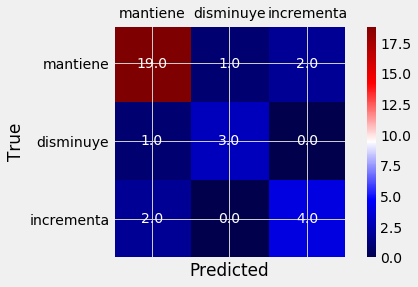

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       0.67      0.67      0.67         6
    mantiene       0.86      0.86      0.86        22

    accuracy                           0.81        32
   macro avg       0.76      0.76      0.76        32
weighted avg       0.81      0.81      0.81        32

---------Modelo 2-grama----------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
el % de clases bien clasificadas es: 81.25
[[21  1  0]
 [ 1  3  0]
 [ 4  0  2]]


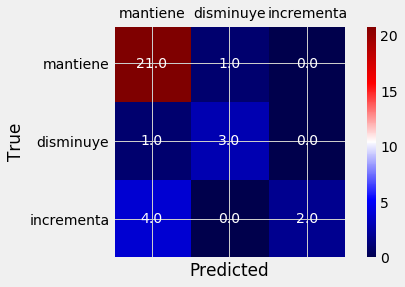

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       1.00      0.33      0.50         6
    mantiene       0.81      0.95      0.88        22

    accuracy                           0.81        32
   macro avg       0.85      0.68      0.71        32
weighted avg       0.84      0.81      0.79        32

---------Modelo sólo palabras----------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
el % de clases bien clasificadas es: 81.25
[[20  1  1]
 [ 1  3  0]
 [ 3  0  3]]


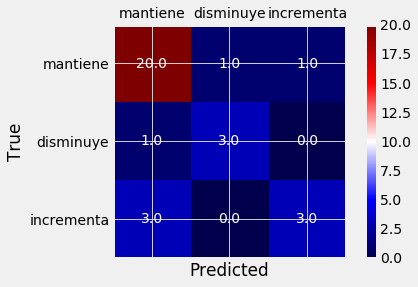

              precision    recall  f1-score   support

   disminuye       0.75      0.75      0.75         4
  incrementa       0.75      0.50      0.60         6
    mantiene       0.83      0.91      0.87        22

    accuracy                           0.81        32
   macro avg       0.78      0.72      0.74        32
weighted avg       0.81      0.81      0.80        32



In [51]:
print("---------Modelo 4-grama--------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------------")

kpis(df_test["category"],preds[3])
print("---------Modelo 2-grama----------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------------")

kpis(df_test["category"],preds[1])
print("---------Modelo sólo palabras----------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------------")

kpis(df_test["category"],df_test["pred"])

**Conclusión:**

De acuerdo con las matrices de confusión podemos ver el recall de las clases mantiene y disminuye se ve mejor en el modelo 2-grama, pero el recall de la clase "disminuye" es el peor de los 3, el mejor en este último caso se da en el modelo 4-grama, donde también en general se tiene mejor f1-score por clase que no es otra cosa que un equilibrio entre recall y precision, pero el **mejor** promedio ponderado de f1-score de todas las clases es el del modelo 4-grama .81 vs. .79 del modelo 2-grama vs. .8 del modelo con sólo palabras... dado esto nos quedamos con el modelo 4-grama como el mejor.

In [53]:
import ipywidgets
ipywidgets.__version__

'7.5.1'